In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline

In [27]:
df = pd.read_csv('../data/ml_features_subset.csv')
df.columns

Index(['date', 'spike_30', 'past_spikes_30', 'wind_speed', 'precipitation',
       'hdd', 'cdd', 'past_da_load_error', 'past_da_price_error', 'month',
       'hour', 'is_weekend', 'is_holiday', 'load_capacity_ratio'],
      dtype='object')

In [28]:
df.set_index('date', inplace= True)

In [29]:
gaussian = ['wind_speed']
uniform = ['hour', 'month']
skewed = ['hdd', 'cdd', 'past_spikes_30', 'precipitation', 'load_capacity_ratio', 'past_da_load_error', 'past_da_price_error']

In [30]:
# Create transformers
gaussian_transformer = StandardScaler()
uniform_transformer = MinMaxScaler()
skewed_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(np.log1p)),
    ('scaler', StandardScaler())
])

In [31]:
preprocessor = ColumnTransformer(transformers=[
    ('gaussian', gaussian_transformer, gaussian),
    ('uniform', uniform_transformer, uniform),
    ('skewed', skewed_transformer, skewed)
])


In [32]:
transformed_data = preprocessor.fit_transform(df)

# Convert back to DataFrame with original column names
transformed_df = pd.DataFrame(
    transformed_data,
    columns=gaussian + uniform + skewed
)

In [33]:
df['past_da_load_error'] = np.log1p(df['past_da_load_error'])
df['past_da_price_error'] = np.log1p(df['past_da_price_error'])
df['hdd'] = np.log1p(df['hdd'])
df['cdd'] = np.log1p(df['cdd'])


In [34]:
df.describe()

,spike_30,past_spikes_30,wind_speed,precipitation,hdd,cdd,past_da_load_error,past_da_price_error,month,hour,is_weekend,is_holiday,load_capacity_ratio
count,52093.000000,52093.000000,52093.000000,52093.000000,52093.000000,52093.000000,52093.000000,52093.000000,52093.000000,52093.000000,52093.000000,52093.000000,52093.000000
mean,0.082295,1.972453,12.461831,0.137347,1.546417,0.526446,13.541838,9.192546,6.552915,11.501603,0.284952,0.001382,1.112189
std,0.274816,3.321285,7.030435,1.357287,1.223799,0.840656,1.259923,1.640390,3.450702,6.921909,0.451396,0.037152,0.401073
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.981788,5.206571,1.000000,0.000000,0.000000,0.000000,0.001225
25%,0.000000,0.000000,6.989936,0.000000,0.000000,0.000000,12.664759,8.010796,4.000000,6.000000,0.000000,0.000000,0.833774
50%,0.000000,1.000000,11.246759,0.000000,1.931884,0.000000,13.457861,8.971043,7.000000,12.000000,0.000000,0.000000,1.002247
75%,0.000000,2.000000,16.854767,0.000000,2.677763,1.162369,14.364780,10.183914,10.000000,18.000000,1.000000,0.000000,1.286311
max,1.000000,24.000000,55.447014,64.100000,3.598750,2.959976,17.496724,17.436529,12.000000,23.000000,1.000000,1.000000,6.555103


In [35]:
transformed_df.describe()

,wind_speed,hour,month,hdd,cdd,past_spikes_30,precipitation,load_capacity_ratio,past_da_load_error,past_da_price_error
count,5.209300e+04,52093.000000,52093.000000,5.209300e+04,5.209300e+04,5.209300e+04,5.209300e+04,5.209300e+04,5.209300e+04,5.209300e+04
mean,-3.491812e-17,0.500070,0.504810,6.547147e-18,-3.055335e-17,-3.273573e-17,8.456731e-18,6.939976e-16,1.296335e-15,4.015583e-16
std,1.000010e+00,0.300953,0.313700,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00
min,-1.772572e+00,0.000000,0.000000,-1.263632e+00,-6.262382e-01,-8.729893e-01,-1.940532e-01,-4.338010e+00,-3.619345e+00,-2.429918e+00
25%,-7.783227e-01,0.260870,0.272727,-1.263632e+00,-6.262382e-01,-8.729893e-01,-1.940532e-01,-7.479819e-01,-6.961442e-01,-7.204153e-01
50%,-1.728319e-01,0.521739,0.545455,3.149786e-01,-6.262382e-01,-1.215122e-02,-1.940532e-01,-2.265576e-01,-6.665341e-02,-1.350323e-01
75%,6.248516e-01,0.782609,0.818182,9.244629e-01,7.564675e-01,4.914068e-01,-1.940532e-01,5.604983e-01,6.531746e-01,6.043549e-01
max,6.114215e+00,1.000000,1.000000,1.677034e+00,2.894825e+00,3.124619e+00,1.592994e+01,7.651449e+00,3.139021e+00,5.025673e+00


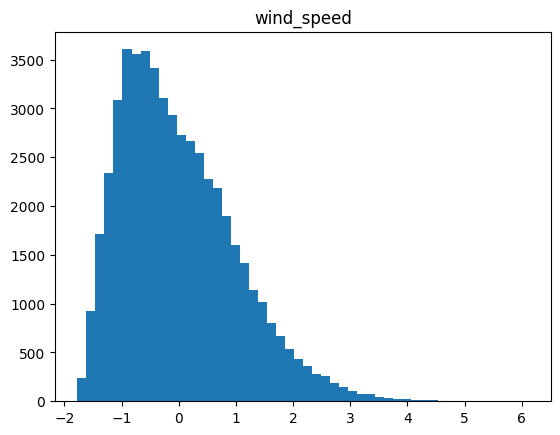

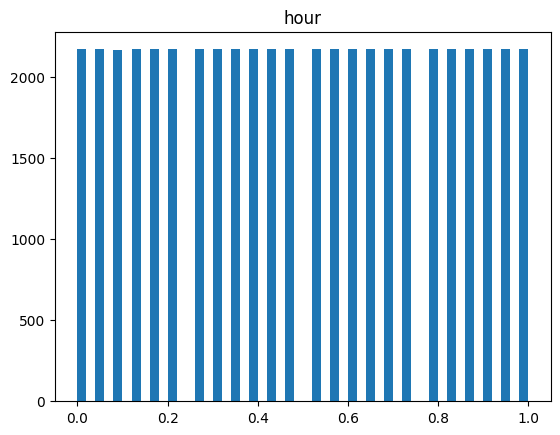

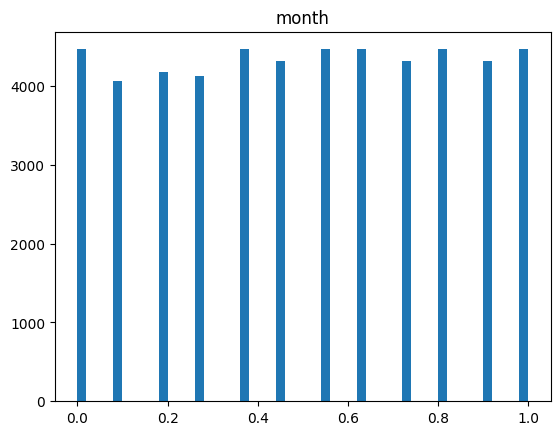

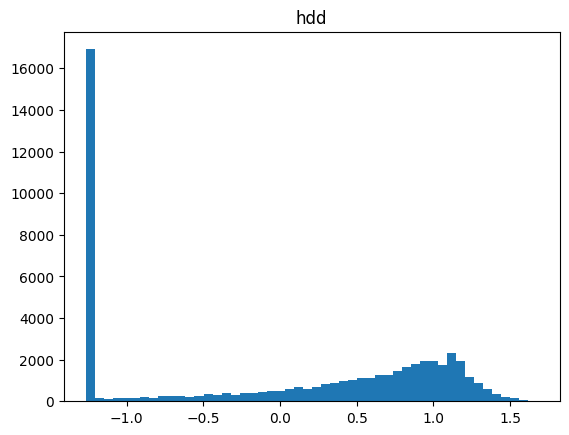

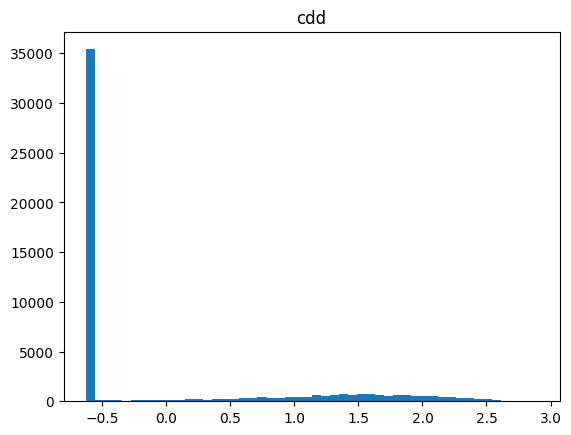

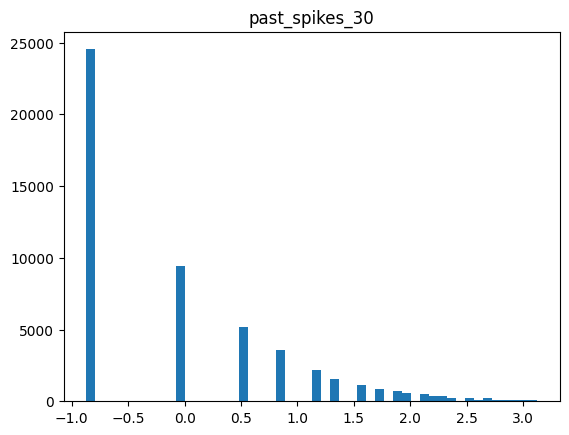

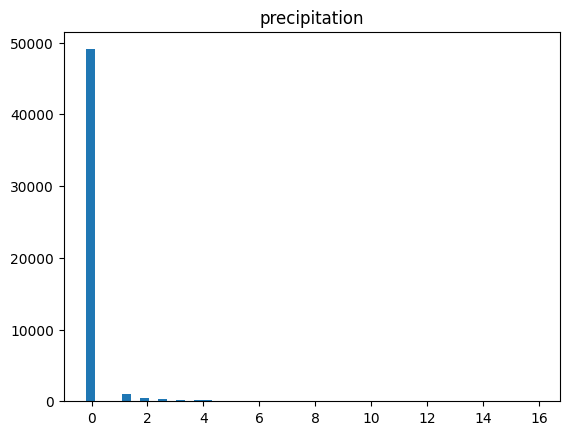

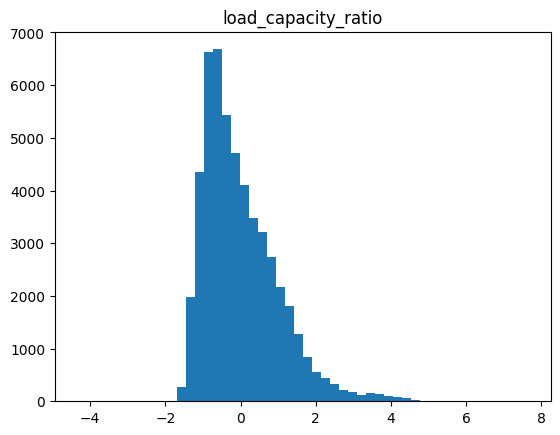

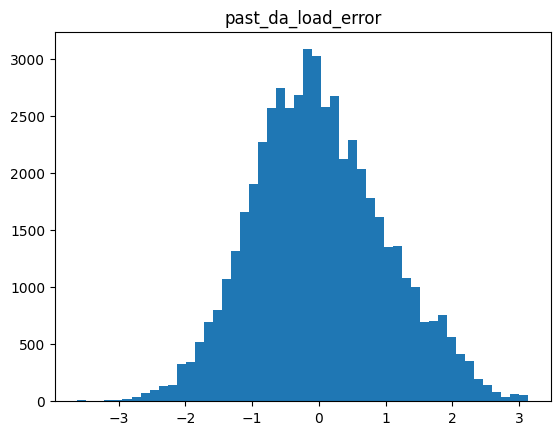

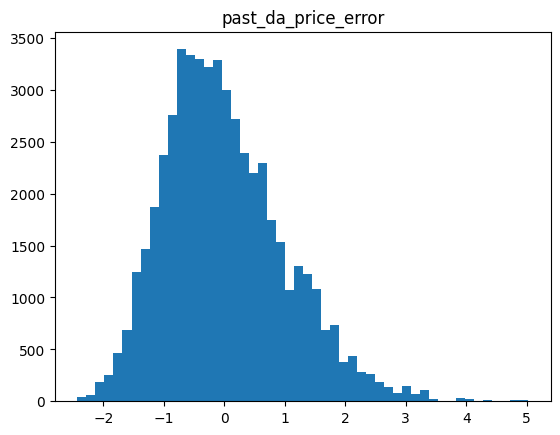

In [38]:
for col in transformed_df.columns:
    plt.hist(transformed_df[col], bins= 50)
    plt.title(col)
    plt.show()

In [37]:
idx = df['load_capacity_ratio'].argmax()
print(df['da_prices'].shift(24).iloc[idx])
print(df['da_prices'].iloc[idx-24])

KeyError: 'da_prices'

In [ ]:
idx = df['load_capacity_ratio'].argmax()
pd.set_option('display.float_format', '{:.5f}'.format)
print(df.index[idx-24], df['da_prices'].shift(24).iloc[idx])
print(df.index[idx], df['rt_prices'].iloc[idx])

2019-12-11 13:00:00 35.5
2019-12-12 13:00:00 30.2675
